# PyTorch - homework TF 3: generative convolutional models

-- Prof. Dorien Herremans

Please run the whole notebook with your code and submit the `.ipynb` file on eDimension that includes your answers [so after you run it]. 

In [1]:
from termcolor import colored

student_number="1003056"
student_name="Ivan Christian"

print(colored("Homework by "  + student_name + ', number: ' + student_number,'red'))

Homework by Ivan Christian, number: 1003056


 ## Question 1 -- Generate images based on a condition

Task: develop a generative model (either cGAN or cVaE) that can generate images based on a class label (bee or ant). 

a) Training dataset: small subset of ImageNet: https://download.pytorch.org/tutorial/hymenoptera_data.zip. You can leverage the ImageFolder class as demonstrated here: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html. Since we don't need a test set for generation, you can combine both test and training datasets. 

To handle using custom datasets, torchvision provides a datasets.ImageFolder class. ImageFolder expects data to be stored in the following way:

*   root/class_x/xxy.png
*   root/class_x/xxz.jpg
*   root/class_y/123.jpeg
*   root/class_y/nsdf3.png
*   root/class_y/asd932_.jpg

b) Normalize the training data and perform data augmentation. For those interested in knowing how to calculate the means for normalizing, please refer to this excellent resource here: https://github.com/bentrevett/pytorch-image-classification/blob/master/5%20-%20ResNet.ipynb and the previously mentioned link. 



In [2]:
%matplotlib inline
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import numpy as np
import os
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
'''
Data Augmentation 
'''
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
# load images and normalize + augment data
data_dir = 'data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x])for x in ['train', 'val']} #normalisation and data augmentation
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


c) Show a few images from the dataset so we understand what we are working with. 



In [5]:
# explore the data
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

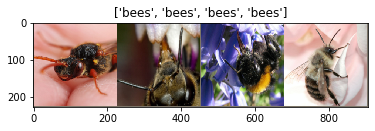

In [6]:
inputs, classes = next(iter(dataloaders['train']))
out = make_grid(inputs)
class_names = image_datasets['train'].classes
imshow(out, title=[class_names[x] for x in classes])


d) Implement a conditional generative model. Use at least one convolutional layer in your generative model and define a loss function that makes sense for this problem. 


In [7]:
# your model here

'''
Discriminator
'''
class Discriminator (nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(4, 20)
        
        self.conv1 = nn.Conv2d(3, 64, 5, 1, 2)
        self.maxpool1 = nn.MaxPool2d(5)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(5)
        self.conv2 = nn.Conv2d(64, 32, 5, 1, 2)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32*224*224+20, 32)
        self.fc2 = nn.Linear(32, 1)
        
        self.fc3 = nn.Linear (4, 20)
        
    def forward(self, x, labels):
        batch_size = x.size(0)
        x = x.view(batch_size, 3, 224, 224)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x,0.2,inplace=True)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x,0.2,inplace=True)
        
        x = x.view(batch_size, 32*224*224) #Flatten
        
        #float? its int64
#         y_ = self.fc3(labels)
        y_ = self.label_emb(labels)
#         y_ = F.relu(y_)
        y_ = F.leaky_relu(y_,0.2,inplace=True)
        
        x = torch.cat([x,y_],1)
        
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        
        return torch.sigmoid(x).squeeze()

In [8]:
'''
Generator
'''

class Generator (nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.z_dim = 20
        self.label_emb = nn.Embedding(4, 20)
        
        self.fc2 = nn.Linear(4, 20)
        self.fc1 = nn.Linear(self.z_dim + 20, 32 *224 * 224)
        
        self.bn2 = nn.BatchNorm2d(32)
        self.deconv2 = nn.ConvTranspose2d(32 , 64, 5, 1, 2)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.deconv1 = nn.ConvTranspose2d(64, 3, 5, 1, 2)
        
    def forward (self, x, labels):
        batch_size = x.size(0)
        
        
#         y_ = self.fc2(labels)
        y_ = self.label_emb(labels)
#         y_ = F.relu(y_)
        y_ = F.leaky_relu(y_,0.2,inplace=True)
        
        x = torch.cat([x,y_], 1)
        
        x = self.fc1(x)
        x = x.view(batch_size, 32, 224, 224)
        
        x = self.bn2(x)
        x = F.leaky_relu(x,0.2,inplace=True)
        x = self.deconv2(x)
        
        x = self.bn1(x)
        x = F.leaky_relu(x,0.2,inplace=True)
        x = self.deconv1(x)
        
        x = torch.sigmoid(x)
        
        return x

In [9]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)


e) Train the network on cuda (I recommend to be clever and use a technique such as mini batches to train effectively, optional though). Show how the loss of the model evolves during training. 

f) Generate 4 images of each class after a number of epochs so we can see the generation quality improving during training.





In [10]:
def discriminator_train_step(batch_size, discriminator,generator, d_optimizer, criterion, real_images, labels):
    discriminator.train()
    generator.train()
    d_optimizer.zero_grad()    
    real_validity = discriminator(real_images,labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
    
    z = Variable(torch.randn(batch_size, 20)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 2, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    # optimize the sum of both losses
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.data

In [11]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    generator.train() # training phase
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 20)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 1, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.data

Starting epoch 1
g_loss: 0.0, d_loss: 6.907755374908447


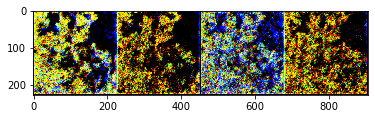

Starting epoch 2
g_loss: 0.0, d_loss: 13.815510749816895


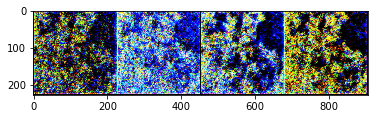

Starting epoch 3
g_loss: 0.0, d_loss: 20.7232666015625


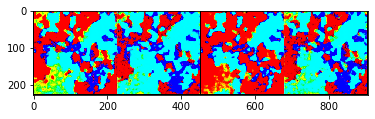

Starting epoch 4
g_loss: 0.0, d_loss: 13.815510749816895


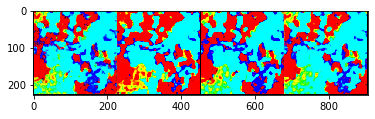

Starting epoch 5
g_loss: 0.0, d_loss: 13.815510749816895


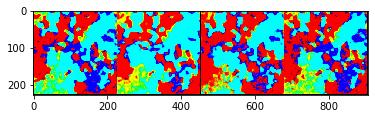

Starting epoch 6
g_loss: 0.0, d_loss: 27.63102149963379


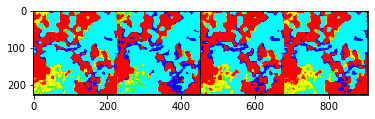

Starting epoch 7


In [ ]:
# train the network
epochs = 30
display_step = 300

from tqdm import tqdm

for i in range(epochs):
    print(f'Starting epoch {i+1}')
    for idx, (image, labels) in enumerate(dataloaders['train']):
            
        real_images = image.to('cuda')
        labels = labels.to('cuda')
        
        
        
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
        
    generator.eval()
    print(f'g_loss: {g_loss}, d_loss: {d_loss}')
    z = Variable(torch.randn(4, 20)).cuda()
    
    labels = Variable(torch.LongTensor(np.random.randint(0, 1, batch_size))).cuda()
    sample_images = generator(z, labels).data.cpu()


    grid = make_grid(sample_images).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()
    

g) Does this model work well enough? What might be the reason for this? 

[your answer]